In [1]:
!pip install gymnasium
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats

You should consider upgrading via the 'C:\Users\vrajp\python_stuff\venvs\vraj_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# define the Function approximator class
class FunctionApproximator:
    def __init__(self, num_bins, num_actions, alpha):
        num_features = num_bins * 4
        self.alpha = alpha
        self.weights = np.random.uniform(-0.001, 0.001, size=(num_features, num_actions))
    
    def __call__(self, state):
        # Return the value of the function approximator for the given state
        result = np.dot(state, self.weights)
        return result

    def update(self, state, error, alpha):
        gradient =  error * alpha
        self.weights +=  state.transpose() * gradient 

    def update_q_learning(self, state, error, alpha):
        gradient =  error * alpha
        self.weights +=  state.transpose() @ gradient 

    def policy_update(self, state, error, alpha):
        gradient = alpha * error
        self.weights +=  state.transpose() @ gradient 

    def policy_update_V2(self, state, action, probs, td_error, alpha):
        s = probs.reshape(-1, 1)
        grad_soft = np.diagflat(s)- np.dot(s, s.T)
        grad_soft = grad_soft[action, :]
        dsoft = grad_soft / probs[0, action]
        grad = state.T.dot(dsoft[None, :])
        gradient =  grad * alpha * td_error
        self.weights +=  gradient 


In [3]:
def q_learning(env, num_episodes, alpha, epsilon, gamma):
    num_bins = 10
    num_states = num_bins ** env.observation_space.shape[0]
    num_actions = env.action_space.n
    # define Q
    Q = FunctionApproximator(num_bins, num_actions=num_actions, alpha=alpha)
    rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        state = env.reset()[0]
        state = discretize_state(state, num_bins)
        done = False
        while not done:
            td_error = np.zeros([1, num_actions])
            action = epsilon_greedy_policy_q_learning(Q, state, epsilon)
            # take action
            next_state, reward, done, _, _  = env.step(action)
            next_state = discretize_state(next_state, num_bins)
            # update Q-values using TD learning
            td_error[0, action] = reward + gamma * np.max(Q(next_state)) * (not done) - Q(state)[0, action]
            td_target = Q(state)[0, action] + alpha * td_error
            Q.update_q_learning(state, td_error, alpha)
            state = next_state
            rewards[episode] += reward
    return rewards

# define the actor critic function
def actor_critic(env, num_episodes, alpha, num_bins=10):
    gamma = 0.9
    num_states = num_bins ** env.observation_space.shape[0]
    num_actions = env.action_space.n
    # define the value function and the policy
    V = FunctionApproximator(num_bins, 1, alpha)
    policy = FunctionApproximator(num_bins, num_actions, alpha)
    rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        state = env.reset()[0]
        state = discretize_state(state, num_bins=num_bins)
        done = False
        while not done:
            p = np.zeros(num_actions)
            # td_error = np.zeros([1, num_actions])
            probs = softmax_policy_gradient_v2(policy, state)
            action = np.random.choice(num_actions, p=probs)
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, num_bins=num_bins)
            # update the value function
            td_error = reward + gamma * (not done) * V(next_state) - V(state)
            V.update(state, td_error, alpha)

            # update the policy function
            p[action] = 1 - probs[action] 
            policy.policy_update(state, p * td_error, alpha)
            state = next_state
            rewards[episode] += reward
            # env.render()

    return rewards

def discretize_state(state, num_bins):
    dis = [
        [-4.8, 4.8],
        [-2.5, 2.5],
        [-0.418, 0.418],
        [-3.8, 3.7]
    ]
    # return np.array(discretized_state).flatten().reshape(1, 40)
    discretized_state = [np.zeros(10) for i in range(4)]

    for i, distance in enumerate(dis):
      a = np.histogram_bin_edges(distance, bins=num_bins - 2)
      c = np.digitize(state, a) 
      discretized_state[i][c[i]] = float(1)

    return np.array(discretized_state).flatten().reshape(1, 40)

def epsilon_greedy_policy(policy, probs, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(policy.weights.shape[1])
    else:
        return np.argmax(probs)

def epsilon_greedy_policy_q_learning(Q, state, epsilon):
    # print("Shape of Q weights:", Q.weights.shape[1])
    if np.random.random() < epsilon:
        return np.random.randint(Q.weights.shape[1])
    else:
        return np.argmax(Q(state))

def softmax_policy_gradient(policy, state, action):
    logits = policy(state)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    probs = probs.ravel()
    probs[action] -= 1

    return probs

def softmax_policy_gradient_v2(policy, state):
    logits = policy(state)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    # print("Current probs is: ", probs)
    probs = probs.ravel()
    return probs


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [4]:
def run_experiment(algorithm, env, num_runs, num_episodes, alpha_list, epsilon_list, num_bins):
    # initialize learning curves
    all_rewards = np.zeros((len(epsilon_list), len(alpha_list), num_runs, num_episodes))
    
    # iterate over epsilon values
    for epsilon_idx, epsilon in enumerate(epsilon_list):
        # iterate over alpha values
        for alpha_idx, alpha in enumerate(alpha_list):
            # iterate over runs
            for run in range(num_runs):
                # set random seed for reproducibility
                np.random.seed(run)
                
                # select gamma = 0.9 at this point
                if algorithm == 'q_learning':
                    rewards = q_learning(env, num_episodes, alpha, epsilon, gamma = 0.9)
                else:
                    rewards = actor_critic(env, num_episodes, alpha, num_bins)
                # run algorithm and store rewards
                all_rewards[epsilon_idx, alpha_idx, run, :] = rewards
    
    # calculate mean and standard error of rewards across runs for each parameter setting
    mean_rewards = np.mean(all_rewards, axis=2)
    std_err_rewards = np.std(all_rewards, axis=2) / np.sqrt(num_runs)
    
    return mean_rewards, std_err_rewards

In [5]:
env = gym.make('CartPole-v1')
num_episodes = 1000
num_bins = 10

# define hyperparameters
alpha_list = [0.25, 0.125, 0.0625]
epsilon_list = [0.1, 0.05, 0.008]

# run experiments for q learning and actor-critic
num_runs = 10
q_learning_mean_rewards, q_learning_std_err_rewards = run_experiment('q_learning', env, num_runs=10, num_episodes=1000, alpha_list=alpha_list, epsilon_list=epsilon_list, num_bins=10)

# plot results



NameError: name 'f' is not defined

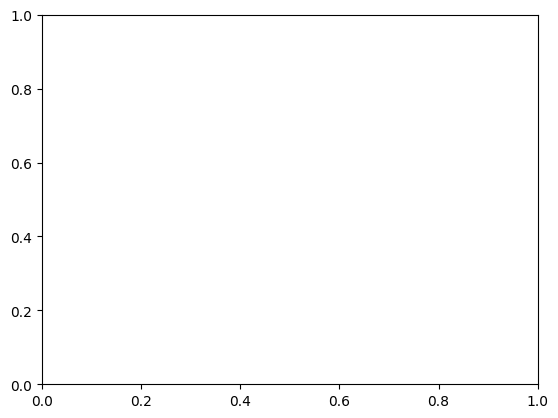

In [7]:
for epsilon_idx, epsilon in enumerate(epsilon_list):
    # plot the rewards in each episode for each run
    fig, ax = plt.subplots()
    for alpha_idx, alpha in enumerate(alpha_list):
        # Plot for each algorithm 3 graphs, one for each , containing the average and standard error of the learning curves for each value of α (each graph will have 3 curves).
        # ax.plot(scalex=np.arange(1, 1001), data=q_learning_mean_rewards[alpha_idx], label=f'alpha={alpha}')
        if epsilon == 0.1 or epsilon == 0.05:
          ax.plot(np.arange(1, 1001), q_learning_mean_rewards[epsilon_idx, alpha_idx], label=f, alpha={alpha})
          ax.fill_between(np.arange(1, 1001), q_learning_mean_rewards[epsilon_idx, alpha_idx] - q_learning_std_err_rewards[epsilon_idx, alpha_idx], q_learning_mean_rewards[epsilon_idx, alpha_idx] + q_learning_std_err_rewards[epsilon_idx, alpha_idx], alpha=0.2)
        else :
          ax.plot(np.arange(1, 1001), q_learning_mean_rewards[epsilon_idx, alpha_idx], label=f, alpha={alpha})
          ax.fill_between(np.arange(1, 1001), q_learning_mean_rewards[epsilon_idx, alpha_idx] - q_learning_std_err_rewards[epsilon_idx, alpha_idx], q_learning_mean_rewards[epsilon_idx, alpha_idx] + q_learning_std_err_rewards[epsilon_idx, alpha_idx], alpha=0.2)
    ax.legend()
    plt.ylim(0, 170)
    ax.set_title(f"Q-Learning: Epsilon={epsilon}")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Total Reward")
    plt.show()




In [8]:
# For actor critic loop only
actor_critic_epsilon_list = [1]
actor_critic_mean_rewards, actor_critic_std_err_rewards = run_experiment('actor_critic', env, num_runs=10, num_episodes=1000, alpha_list=alpha_list, epsilon_list=actor_critic_epsilon_list, num_bins=10)


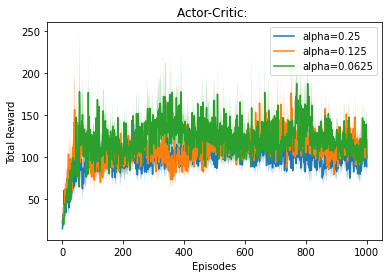

In [28]:
for epsilon_idx, epsilon in enumerate(actor_critic_epsilon_list):
    fig, ax = plt.subplots()
    for alpha_idx, alpha in enumerate(alpha_list):
        ax.plot(np.arange(1, 1001), actor_critic_mean_rewards[epsilon_idx, alpha_idx], label=f'alpha={alpha}')
        ax.fill_between(np.arange(1, 1001), actor_critic_mean_rewards[epsilon_idx, alpha_idx] - actor_critic_std_err_rewards[epsilon_idx, alpha_idx], actor_critic_mean_rewards[epsilon_idx, alpha_idx] + actor_critic_std_err_rewards[epsilon_idx, alpha_idx], alpha=0.4)
    ax.legend()
    ax.set_title(f"Actor-Critic: ")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Total Reward")
    plt.show()

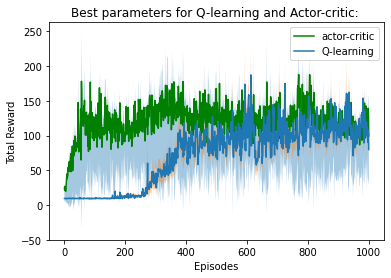

In [29]:
### Best parameter choice for Q-Learning
# epsilon = 0.008 and alpha = 0.0625
### Best parameter choice for Actor-Critic
# alpha = 0.0625

fig, ax = plt.subplots()
ax.plot(np.arange(1, 1001), actor_critic_mean_rewards[0, 2], label=f'actor-critic', color='green')
ax.fill_between(np.arange(1, 1001), q_learning_mean_rewards[0, 2] - actor_critic_std_err_rewards[0, 2], actor_critic_mean_rewards[0, 2] + actor_critic_std_err_rewards[0, 2], alpha=0.4)
ax.plot(np.arange(1, 1001), q_learning_mean_rewards[2, 2], label=f'Q-learning')
ax.fill_between(np.arange(1, 1001), q_learning_mean_rewards[2, 2] - q_learning_std_err_rewards[2, 2], q_learning_mean_rewards[2, 2] + q_learning_std_err_rewards[2, 2], alpha=0.4)
ax.legend()
ax.set_title(f"Best parameters for Q-learning and Actor-critic: ")
ax.set_xlabel("Episodes")
ax.set_ylabel("Total Reward")
plt.show()


In [30]:
print(actor_critic_mean_rewards[0, 2].mean())

120.2845


In [31]:
print(q_learning_mean_rewards[2, 2].mean())

71.21539999999999
